In [1]:
import pandas as pd
import itertools
import seaborn as sns
from db import get_df, Database
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib import gridspec, pyplot as plt


set_matplotlib_formats('svg')

pd.set_option('display.max_rows', None)

__pcaps = {}

def get_pcaps(slot_h=1.):
    if slot_h in __pcaps:
        return __pcaps[slot_h]
    
    db = Database()

    DF_FP = get_df(db, 'normal', None, True, 'nx', slot_h=slot_h).iloc[0:int(8/slot_h)]

    dfs = {
        'healthy': DF_FP,
        'caphaw': get_df(db, 'caphaw', 54, True, 'nx'),
        'zbot': get_df(db, 'zbot', 46, True, 'nx'),
        'simda': get_df(db, 'simda', 58, True, 'nx'),
        'unknown': get_df(db, 'unknown', 57, True, 'nx'),
    }
    return dfs


In [2]:

def simulate_pcaps(dfs, slot_h, window_slots, sigma_fp_ratio=1.0, mus_ratios=[0.5,1.0,1.5]):

    res = []
    for mw in dfs:
        if mw == 'healthy':
            continue
        df_tp = dfs[mw]
        skipped_all = 0
        skipped_any = 0
        for w in range(0, int(24*30/slot_h)):
            tps = df_tp.iloc[w:w + window_slots]['pp'].reset_index(drop=True)

            if tps.shape[0] < window_slots:
                break

            for mus_ratio in mus_ratios:
                mu_fp = tps.mean() / mus_ratio
                sigma_fp = mu_fp * sigma_fp_ratio

                fps = np.random.normal(mu_fp, sigma_fp, tps.shape[0])

                labels = tps > 0

                if labels.all() or labels.any() == False:
                    skipped_all += labels.all()
                    skipped_any += labels.any() == False
                    continue

                fpr, tpr, thresholds = roc_curve(labels, (fps + tps), drop_intermediate=False)
                roc_auc = auc(fpr, tpr)

                mask = fpr < 0.01
                pAUCs_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)

                try:
                    pAUC_001 = auc(fpr[mask], tpr[mask])
                except:
                    pAUC_001 = np.nan
                    pass

                res.append([
                    mw,
                    w,
                    mus_ratio,
                    sigma_fp_ratio,
                    tps.std() / tps.mean(),
                    mu_fp,
                    sigma_fp,
                    tps.mean(),
                    tps.std(),
                    fpr,
                    tpr,
                    roc_auc,
                    pAUCs_001,
                    pAUC_001
                ])
                pass
            pass
        pass

    DF = pd.DataFrame(res, columns=[
        'mw',
        'w',
        'mus_ratio',
        'sigma_fp_ratio',
        'sigma_tp_ratio',
        'mu_fp',
        'sigma_fp',
        'mu_tp',
        'sigma_tp',
        'fpr',
        'tpr',
        'roc_auc',
        'pAUCs_001',
        'pAUC_001'
    ])

    return DF


In [3]:

slot_h = 1
pcaps = get_pcaps(slot_h)
mus_ratios = [0.5,1.0,1.5]
window_slots = 16
N=4
linspace_num_s = [3]
sigma_fp_ratios = [0.1, 0.5, 1, 2, 4]
dfs = []
for repetition in range(N):
    for sigma_fp_ratio in sigma_fp_ratios:
        df = simulate_pcaps(pcaps, slot_h, window_slots, sigma_fp_ratio=sigma_fp_ratio, mus_ratios=mus_ratios)
        dfs.append(df)
        pass

df = pd.concat(dfs, axis=0)

df.to_pickle(f'DF__sim{N}.csv')

In [5]:
df = pd.read_pickle('DF__sim4.csv')

intervals = 25

df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])

df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=5)
df['sigma_tp_ratio_mid'] = df['sigma_tp_ratio_cat'].apply(lambda x: x.left).astype(np.float64)
# df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=pd.IntervalIndex([ pd.Interval(b[0], b[1], closed='right') for b in bins ]))

df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

df = df.explode(['fpr','tpr'])

df.fpr = df.fpr.apply(lambda x: x.left)
df.tpr = df.tpr.apply(lambda x: x.left)

In [12]:


renamer = {
    'sigma_fp_ratio': '$\\sigma_{fp}/\\mu_{fp}$',
    'sigma_fp_ratio_cat': '$\\sigma_{fp}/\\mu_{fp}\'$',
    'sigma_tp_ratio': '$\\sigma_{tp}/\\mu_{tp}$',
    'sigma_tp_ratio_cat': '$\\sigma_{tp}/\\mu_{tp}\'$',
    'sigma_tp_ratio_mid': '$\\sigma_{tp}/\\mu_{tp}\'\'$',
    'mus_ratio_cat': '$\\mu_{tp}/\\mu_{fp}$'
}

df.rename(columns=renamer).head()

,mw,w,mus_ratio,$\sigma_{fp}/\mu_{fp}$,$\sigma_{tp}/\mu_{tp}$,mu_fp,sigma_fp,mu_tp,sigma_tp,fpr,tpr,roc_auc,pAUCs_001,pAUC_001,$\mu_{tp}/\mu_{fp}$,$\sigma_{tp}/\mu_{tp}'$,$\sigma_{tp}/\mu_{tp}''$
0,caphaw,196,0.5,0.1,4.0,0.25,0.025,0.125,0.5,-0.001,-0.001,1.0,1.0,0.0,0.5,"(3.266, 4.0]",3.266
0,caphaw,196,0.5,0.1,4.0,0.25,0.025,0.125,0.5,-0.001,0.960,1.0,1.0,0.0,0.5,"(3.266, 4.0]",3.266
0,caphaw,196,0.5,0.1,4.0,0.25,0.025,0.125,0.5,0.040,0.960,1.0,1.0,0.0,0.5,"(3.266, 4.0]",3.266
0,caphaw,196,0.5,0.1,4.0,0.25,0.025,0.125,0.5,0.120,0.960,1.0,1.0,0.0,0.5,"(3.266, 4.0]",3.266
0,caphaw,196,0.5,0.1,4.0,0.25,0.025,0.125,0.5,0.160,0.960,1.0,1.0,0.0,0.5,"(3.266, 4.0]",3.266


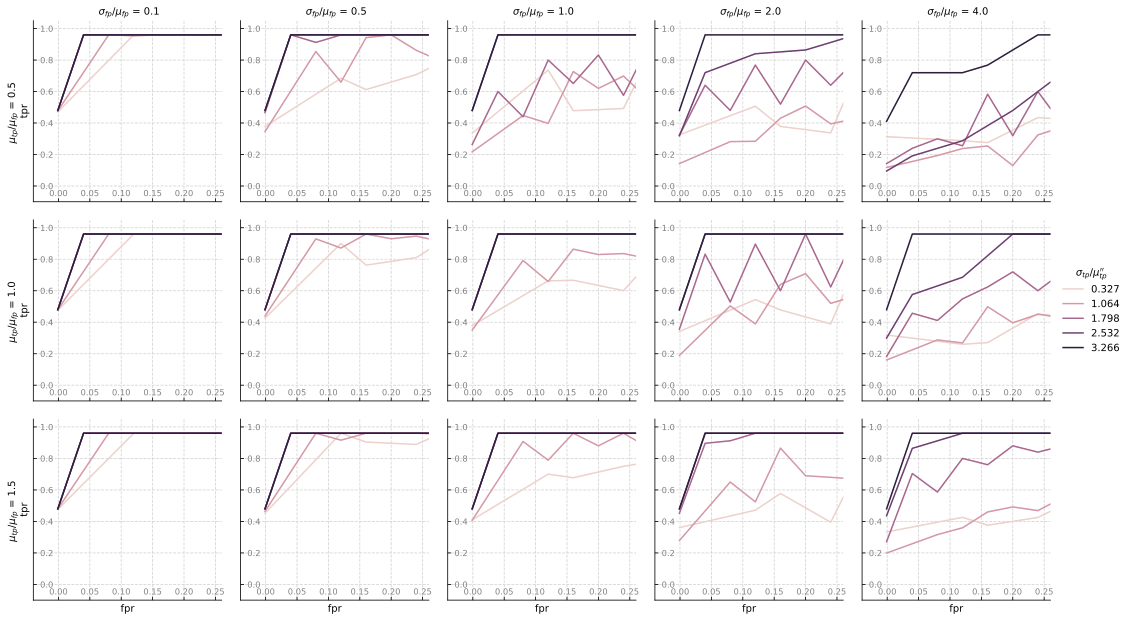

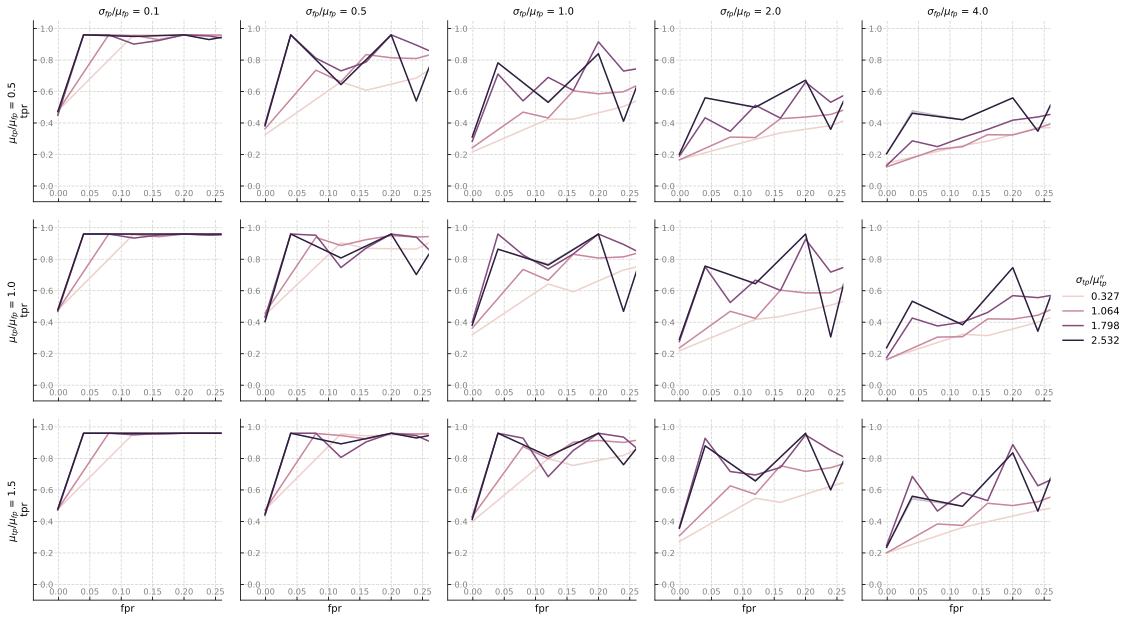

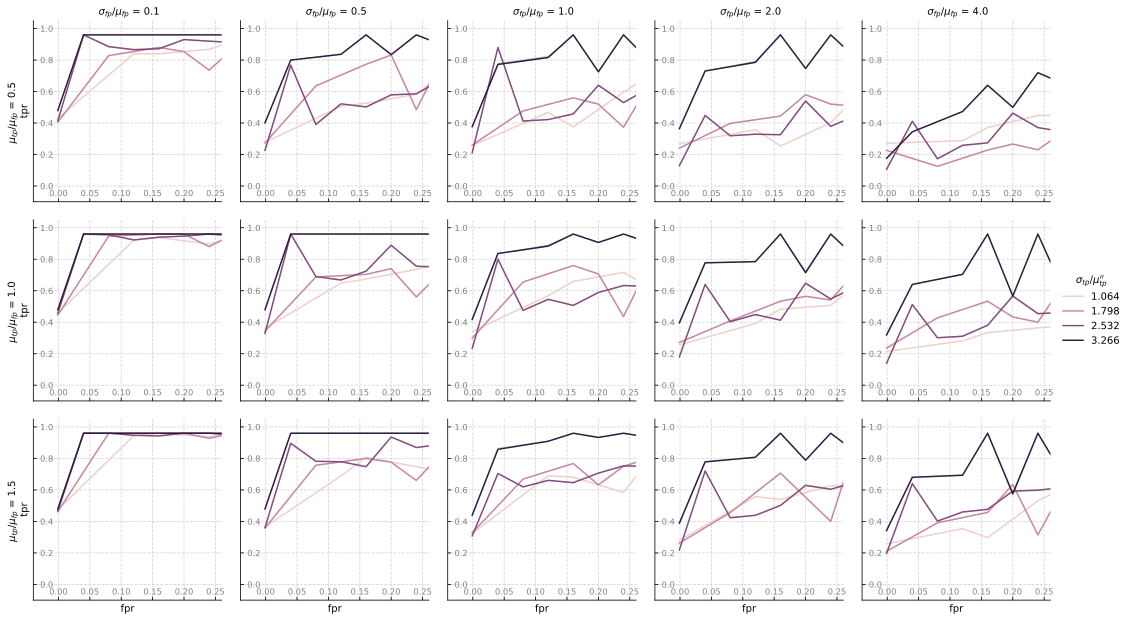

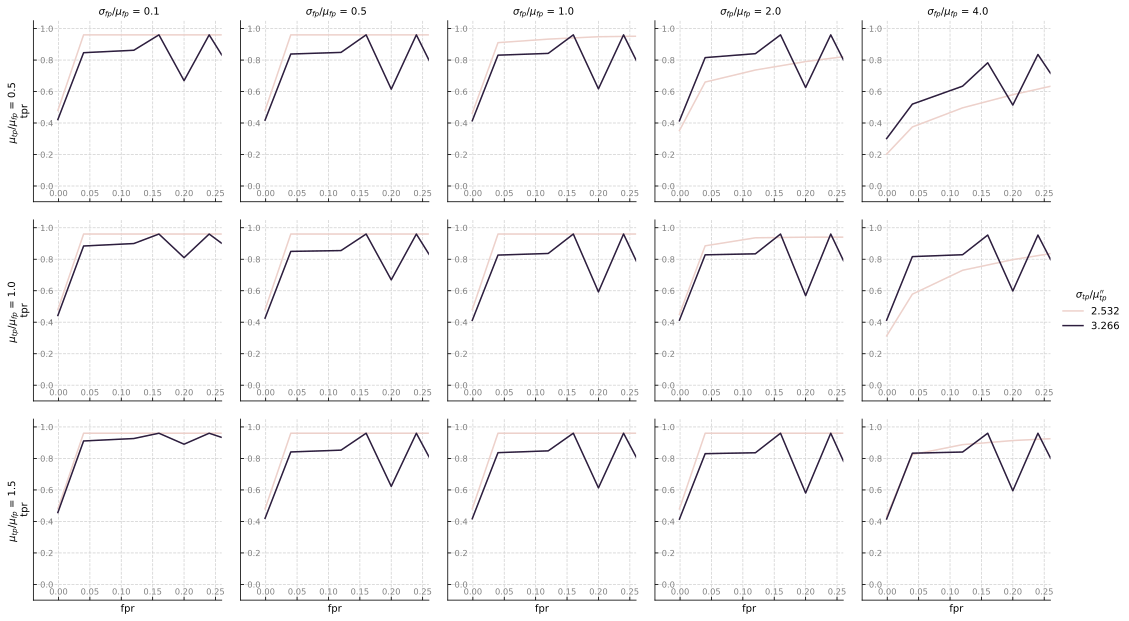

In [13]:

for mw in df.mw.drop_duplicates():
    g = sns.relplot(df[df.mw == mw].rename(columns=renamer),
                    x='fpr', y='tpr',
                    hue=renamer['sigma_tp_ratio_mid'],
                    row=renamer['mus_ratio_cat'], col=renamer['sigma_fp_ratio'],
                    errorbar=('ci', 0.9),
                    kind='line', markers=False, dashes=False,
                    height=3,
                    facet_kws=dict(sharey=False, sharex=False))

    rows = g.axes.shape[0]
    cols = g.axes.shape[1]

    [ g.axes[i,0].set_ylabel(g.axes[i,0].title.get_text().split('|')[0] + '\ntpr') for i in range(rows) ]
    [ g.axes[0,j].set_title(g.axes[0,j].title.get_text().split('|')[1], size='medium') for j in range(cols) ]
    [ g.axes[i,j].set_title('') for i in range(1,rows) for j in range(cols) ]
    [ g.axes[i,j].grid(True, axis='both', linestyle='--', color='lightgray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_yticks(list(map(lambda x: x/5, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xticks(list(map(lambda x: x/20, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="x", direction="in", pad=-12, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="y", direction="in", labeltop=True, pad=-20, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_ylim(-0.1, 1.05) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xlim(-0.04, 0.26) for i in range(rows) for j in range(cols) ]


    plt.gcf().subplots_adjust(hspace=0.1, wspace=0.1)

    plt.gcf().savefig(f'beamer/{mw}.pdf')
    
    pass

In [62]:
def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)

res = []
for mu, sigma_ratio in itertools.product([5, 50, 100], map(lambda x: x/10 + 0.5, range(1,10))):
    sigma = mu*sigma_ratio
    _r, _p= neg_rp(mu, sigma)
    res.append([
        mu, sigma, sigma_ratio, _r, _p
    ])

df = pd.DataFrame(res, columns='mu,sigma,sigma_ratio,_r,_p'.split(','))
print(all(df['_r'] > 0), all(df['_p'].between(0,1, inclusive='both')))
display(df)

True True


,mu,sigma,sigma_ratio,_r,_p
0,5,3.0,0.6,6.250000,0.555556
1,5,3.5,0.7,3.448276,0.408163
2,5,4.0,0.8,2.272727,0.312500
3,5,4.5,0.9,1.639344,0.246914
4,5,5.0,1.0,1.250000,0.200000
5,5,5.5,1.1,0.990099,0.165289
6,5,6.0,1.2,0.806452,0.138889
7,5,6.5,1.3,0.671141,0.118343
8,5,7.0,1.4,0.568182,0.102041
9,50,30.0,0.6,2.941176,0.055556
